## Analyze trials

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from concise.hyopt import CompileFN, CMongoTrials, test_fn
import numpy as np
import pandas as ps
from concise.utils.splines import BSpline
from keras.models import load_model
import sklearn.metrics as skm
import concise.eval_metrics as cem
import keras.callbacks as kc
import data
import model
from helper import *

DB_NAME = "Concise__Splice_branchpoints"
exp_name = "model_shallow2"


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database',)).History will not be written to the database.


Using TensorFlow backend.


In [2]:
trials = CMongoTrials(DB_NAME, exp_name, kill_timeout=30 * 60)

In [3]:
df = trials.as_df().sort_values("eval.auprc", ascending=False)
df

,tid,loss,status,eval.accuracy,eval.auc,eval.auprc,eval.f1,eval.fdr,eval.loss,eval.precision,eval.sensitivity,eval.specificity,name.data,name.loss_metric,name.loss_metric_mode,name.model,param.data.n_bases,param.data.pos_class_weight,param.data.truncate,param.fit.batch_size,param.fit.early_stop_monitor,param.fit.epochs,param.fit.patience,param.model.filters,param.model.init_motifs.stddev,param.model.init_motifs.use_pssm,param.model.lr,param.model.nonlinearity,param.model.pos_effect.l2,param.model.pos_effect.l2_smooth,param.model.pos_effect.merge.hidden_fc,param.model.pos_effect.merge.type,param.model.pos_effect.n_bases,param.model.pos_effect.use_bias,path.model,path.results,time.duration.dataload,time.duration.total,time.duration.training,time.end,time.start,n_epoch
188,2663,-0.5955,ok,0.9571,0.9152,0.5955,0.5423,0.2957,0.1277,0.7043,0.4458,0.9885,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,2,1,0.0003,True,0.0042,relu,1.8243e-05,4.8033e-05,NaN,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,103.8865,264.2417,160.3552,2017-05-02 00:36:40.0...,2017-05-02 00:32:15.7...,43
118,2593,-0.5954,ok,0.9574,0.9155,0.5954,0.5285,0.2701,0.1276,0.7299,0.4188,0.9905,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,2,1,0.0031,True,0.0008,relu,8.0912e-06,8.8667e-10,NaN,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,138.3523,445.1432,306.7909,2017-05-02 00:25:55.9...,2017-05-02 00:18:30.7...,88
174,2649,-0.5952,ok,0.9573,0.9152,0.5952,0.5402,0.2878,0.1277,0.7122,0.4400,0.9891,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,2,1,0.0003,True,0.0032,relu,1.4527e-05,2.3460e-10,NaN,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,55.4617,159.9615,104.4999,2017-05-02 00:31:43.5...,2017-05-02 00:29:03.5...,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,2510,-0.1617,ok,0.9425,0.7841,0.1617,NaN,NaN,0.1930,NaN,0.0000,1.0000,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,2,1,0.0017,True,0.0024,relu,1.0066e-10,4.4714e-01,NaN,add,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,56.4052,208.3230,151.9178,2017-05-02 00:03:25.3...,2017-05-01 23:59:57.0...,56
34,2509,-0.1563,ok,0.9425,0.7824,0.1563,NaN,NaN,0.1912,NaN,0.0000,1.0000,data,auprc,auprc,model,10,2.0,True,128,val_loss,150,2,1,0.0003,True,0.0034,relu,1.9862e-08,1.7723e-05,NaN,add,10,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,39.3320,108.7638,69.4318,2017-05-02 00:01:41.5...,2017-05-01 23:59:52.7...,46
1,2476,-0.1558,ok,0.9425,0.7823,0.1558,NaN,NaN,0.1910,NaN,0.0000,1.0000,data,auprc,auprc,model,10,2.0,True,128,val_loss,150,2,1,0.0273,True,0.0026,relu,1.5926e-13,2.8379e-06,NaN,add,10,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,38.9684,112.6443,73.6759,2017-05-01 23:56:13.2...,2017-05-01 23:54:20.6...,45


In [4]:
np.array(df["param.model.init_motifs.use_pssm"]) # mostly use pssm

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True, False,  True,  True,  True, False,  True, False,  True,  True,
        True, False,  True,  True, False, False,  True, False, False, False,  True,  True, False,
       False,  True, False,  True,  True, False,  True,  True,  True, False,  True,  True,  True,
        True, False,  True, False, False,  True,  True, False,  True, False, False, False,  True,
       False,  True, False, False, False, False, False,  True,  True, False, False, False,  True,
        True,  True, False, False,  True, False,  True,  True,  True, False,  True,  True, False,
        True, False, False, False,  True,  True, False, False,  True, False,  True, False, False,
       False, False,  True,  True, False, False, False, False, False,  True, False, False, False,
        True,  True,

In [5]:
np.array(df["param.model.pos_effect.merge.type"])  # mostly concat

array(['concatenate', 'concatenate', 'concatenate', 'concatenate', 'concatenate', 'concatenate',
       'concatenate', 'concatenate', 'concatenate', 'concatenate', 'concatenate', 'concatenate',
       'concatenate', 'concatenate', 'concatenate', 'concatenate', 'concatenate', 'concatenate',
       'concatenate', 'concatenate', 'concatenate', 'concatenate', 'concatenate', 'concatenate',
       'concatenate', 'concatenate', 'concatenate', 'concatenate', 'concatenate', 'concatenate',
       'concatenate', 'add', 'concatenate', 'concatenate', 'concatenate', 'concatenate',
       'concatenate', 'concatenate', 'concatenate', 'add', 'concatenate', 'concatenate',
       'concatenate', 'add', 'concatenate', 'concatenate', 'add', 'concatenate', 'concatenate',
       'add', 'concatenate', 'add', 'concatenate', 'concatenate', 'concatenate', 'concatenate',
       'concatenate', 'concatenate', 'concatenate', 'add', 'concatenate', 'concatenate',
       'concatenate', 'add', 'add', 'concatenate', 'conc

In [4]:
TID = 2593
model_path = df[df["tid"] == TID]["path.model"].iloc[0]
param = trials.get_param(TID).to_dict()
param

{'data': {'n_bases': 30, 'pos_class_weight': 2.0, 'truncate': True},
 'fit': {'batch_size': 128,
  'early_stop_monitor': 'val_loss',
  'epochs': 150,
  'patience': 2},
 'model': {'filters': 1,
  'init_motifs': {'stddev': 0.0030788045383975597, 'use_pssm': True},
  'lr': 0.0007777815337297625,
  'nonlinearity': 'relu',
  'pos_effect': {'l2': 8.091153689707212e-06,
   'l2_smooth': 8.866748668232468e-10,
   'merge': {'hidden_fc': None, 'type': 'concatenate'},
   'n_bases': 30,
   'use_bias': False}}}

In [5]:
m = load_model(model_path)

Removing 1 pwm's from pwm_list
Removing 1 pwm's from pwm_list


In [6]:
train, test = data.data(**param["data"])

KeyboardInterrupt: 

In [10]:
train[0]["dist1"].shape

(28042, 27, 30)

In [11]:
##m.summary()

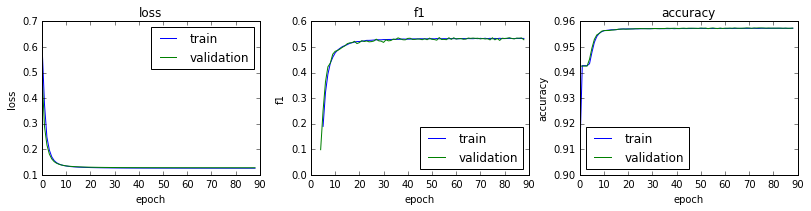

In [22]:
plot_history(trials, TID)

### Evaluate performance

In [23]:
from concise.utils.model_data import split_train_test_idx, subset

train_idx, valid_idx = split_train_test_idx(train, valid_split=.2, stratified=False, random_state=100)

valid = subset(train, valid_idx, keep_other=False)
train_train = subset(train, train_idx)

In [24]:
metrics_dt(m, {"train": train_train, "valid": valid, "test": test})

,dataset,loss,acc,f1,precision,sensitivity,sensitivity,specificity,fdr,auprc,auc
0,train,0.1258,0.9282,0.5293,0.7225,0.4224,0.4224,0.9901,0.2775,0.5983,0.9197
1,test,0.1213,0.9297,0.5190,0.6986,0.4190,0.4190,0.9896,0.3014,0.5834,0.9225
2,valid,0.1276,0.9290,0.5285,0.7299,0.4188,0.4188,0.9905,0.2701,0.5954,0.9155


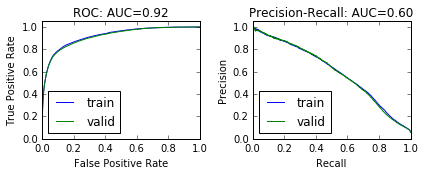

In [25]:
plot_roc_pr(m, [train_train, valid], ["train", "valid"])

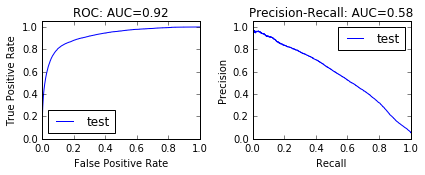

In [16]:
data = plot_roc_pr(m, [test], ["test"], return_data=True)
y_true, y_pred = data[0]

## Export predictions to csv

In [17]:
dt_pred = pd.DataFrame({"y_true": y_true.reshape((-1,)), "y_pred": y_pred.reshape((-1,))})
dt_pred = dt_pred[dt_pred["y_true"] != -1]
dt_pred["y_true"] = np.where(dt_pred["y_true"]== 1, "HC", "NEG")
dt_pred.sort_values("y_pred")

,y_pred,y_true
80353,2.2144e-06,NEG
80352,2.9268e-06,NEG
41878,3.2983e-06,NEG
...,...,...
47297,9.6922e-01,HC
108969,9.7590e-01,HC
197260,9.7594e-01,HC


In [40]:
dt_pred.to_csv("/s/project/deepcis/Concise/Splice_branchpoints/test_predictions/concise_shallow2.csv")

## Model fitting

In [338]:
param["data"]["truncate"] = False  #  this version was ran ignoring the truncate value
train, test = data.data(**param["data"])

In [339]:
m = model.model(**{"train_data": train, **param["model"]})

cur_model = param2str(param)
tb = kc.TensorBoard(log_dir='./logs4/'+ cur_model,
                    histogram_freq=0, 
                    write_graph=False, 
                    write_images=True)
cur_model

'pos_cls_w=None;filt=1;hid_nl=None;type=concat;hid_d=None;hid_n=None;n_bases=30;nl=relu;trunc=True;use_pssm=True;lr=0.00058;1337'

In [341]:
sample_weight = np.squeeze(np.where(train_train[1]==1, param["data"]["pos_class_weight"], 1), -1)
m.fit(train_train[0], train_train[1], epochs=50, 
      batch_size=128,
      sample_weight = sample_weight,
      validation_data=valid,
      callbacks=[kc.EarlyStopping(patience=2), tb])

Train on 22433 samples, validate on 5609 samples
Epoch 1/50
22433/22433 [==============================] - 3s - loss: 0.6625 - accuracy: 0.9329 - f1: nan - precision: nan - sensitivity_1: 0.0031 - sensitivity_2: 0.0031 - specificity: 0.9894 - fdr: nan - val_loss: 0.5070 - val_accuracy: 0.9425 - val_f1: nan - val_precision: nan - val_sensitivity_1: 0.0000e+00 - val_sensitivity_2: 0.0000e+00 - val_specificity: 1.0000 - val_fdr: nan
Epoch 2/50
22433/22433 [==============================] - 2s - loss: 0.5078 - accuracy: 0.9427 - f1: nan - precision: nan - sensitivity_1: 0.0000e+00 - sensitivity_2: 0.0000e+00 - specificity: 1.0000 - fdr: nan - val_loss: 0.3444 - val_accuracy: 0.9425 - val_f1: nan - val_precision: nan - val_sensitivity_1: 0.0000e+00 - val_sensitivity_2: 0.0000e+00 - val_specificity: 1.0000 - val_fdr: nan
Epoch 3/50
22433/22433 [==============================] - 2s - loss: 0.4159 - accuracy: 0.9427 - f1: nan - precision: nan - sensitivity_1: 0.0000e+00 - sensitivity_2: 0.0000

## Model interpretation

- **DONE** - download pwm from 
http://katahdin.mssm.edu/splice/splice_matrix.cgi?database=spliceNew

- **TODO** - read - http://www.nature.com.emedien.ub.uni-muenchen.de/nrg/journal/v17/n1/full/nrg.2015.3.html
- splice-site fractions: http://katahdin.mssm.edu/splice/splicesites.html
   - **U12 = 1%, U2 = 99%**

- **DONE** - initialize once only with U2 and then with U12 branchsite
0, 1 or 2 branchsite inizialized (use int as the variable) 

In [120]:
bp_freq = np.array([169, 1602, 469, 183800])

In [121]:
bp_freq

array([   169,   1602,    469, 183800])

In [122]:
bp_freq / bp_freq.sum()

array([ 0.0009,  0.0086,  0.0025,  0.988 ])

In [ ]:
sum(bp_freq[[0,2]]) / bp_freq.sum()

In [ ]:
sum([169, 1602, 469, 183800])

### PWM

In [7]:
i = 19 if param["model"]["pos_effect"]["merge"]["type"]== "multiply" else 10
m.layers[i].plotFilters()

AttributeError: 'ConvDNA' object has no attribute 'plotFilters'

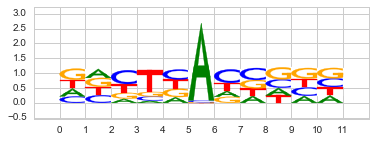

In [11]:
i = 19 if param["model"]["pos_effect"]["merge"]["type"]== "multiply" else 10
m.layers[i].plot_weights(0,"motif_pwm")
# TODO - you need to normalize the plot

In [13]:
# TODO - use the kelley methods?

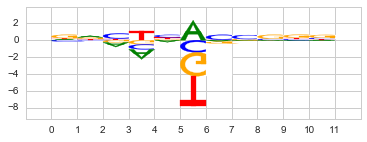

In [12]:
m.layers[i].plot_weights(0,"motif_raw")

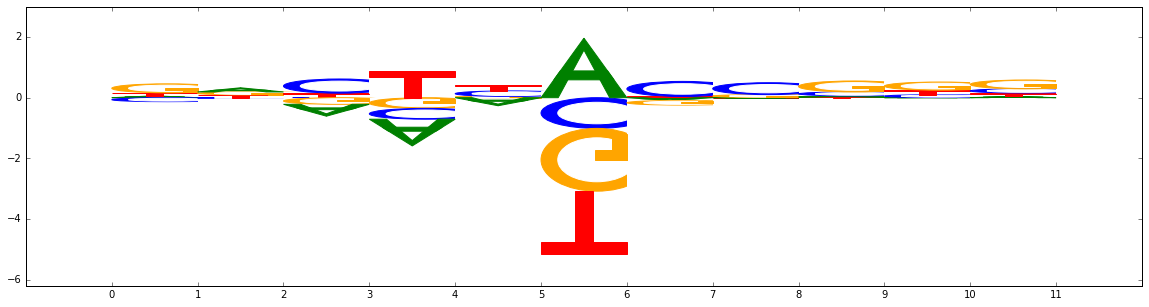

In [367]:
m.layers[i].plotFilter(0, (20, 5))

In [355]:
m.layers[19]

In [ ]:
m.layers[-1].get_weights()

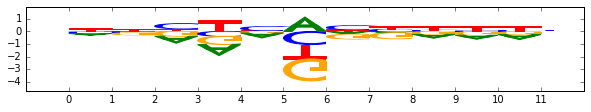

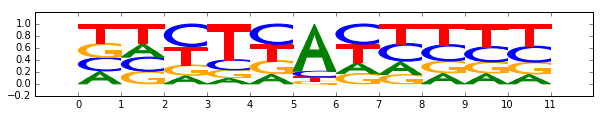

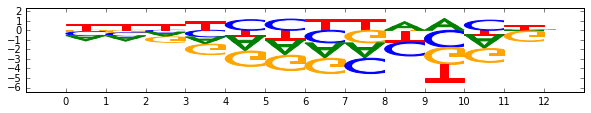

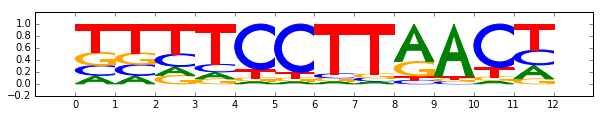

In [387]:
## Train motifs
pwm_list = train[4]
figsize = (10, 1.5)
pwm_list[0].plotPSSM(figsize=figsize)
pwm_list[0].plotPWM(figsize=figsize)
pwm_list[1].plotPSSM(figsize=figsize)
pwm_list[1].plotPWM(figsize=figsize)

The two pssm matrices differ slightly but have the same two strong bases 0:A and -2:T.

### Positional effects

In [62]:
param

{'data': {'n_bases': 20,
  'pos_class_weight': 9.171006099308933,
  'truncate': False},
 'fit': {'batch_size': 128,
  'early_stop_monitor': 'val_loss',
  'epochs': 150,
  'patience': 2},
 'model': {'filters': 1,
  'init_motifs': {'stddev': 0.1, 'use_pssm': True},
  'lr': 0.0034329655705705913,
  'nonlinearity': 'relu',
  'pos_effect': {'l2': 1.071557178101583e-08,
   'l2_smooth': 1.3725606005881432e-07,
   'merge': {'hidden_fc': None, 'type': 'concatenate'},
   'merge_type': 'multiply',
   'n_bases': 20,
   'use_bias': False},
  'use_weightnorm': False}}

In [345]:
position_stats = train[5]
position_stats

{'canon_hit1': {'max': 75.0, 'min': 1.0},
 'canon_hit2': {'max': 150.0, 'min': 3.0},
 'canon_hit3': {'max': 150.0, 'min': 5.0},
 'canon_hit4': {'max': 150.0, 'min': 7.0},
 'canon_hit5': {'max': 150.0, 'min': 10.0},
 'dist1': {'max': 10000.0, 'min': -20.0},
 'dist2': {'max': 44.0, 'min': 18.0},
 'ppt_run_length': {'max': 43.0, 'min': 0.0},
 'ppt_start': {'max': 36.0, 'min': 0.0}}

In [220]:
train[3]

['dist1',
 'dist2',
 'ppt_start',
 'ppt_run_length',
 'canon_hit1',
 'canon_hit2',
 'canon_hit3',
 'canon_hit4',
 'canon_hit5']

In [346]:
w_final = m.layers[-1].get_weights()[0][0,:]
w_final

array([[ 1.1306],
       [-1.042 ],
       [ 1.3441],
       [-1.0234],
       [ 0.954 ],
       [ 1.3813],
       [ 0.9028],
       [-0.789 ],
       [ 0.797 ],
       [ 0.925 ]], dtype=float32)

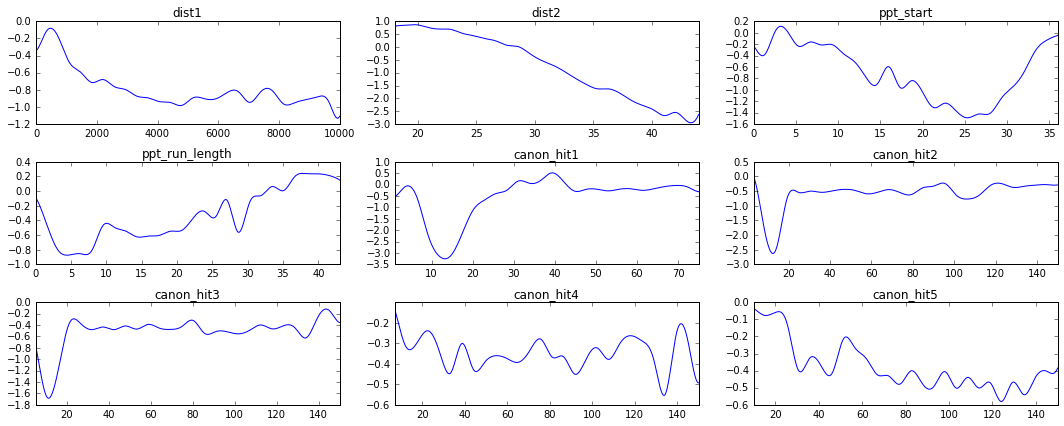

In [27]:
dfpos = plot_pos_dep(m, param, train)

In [384]:
dfpos.head()

,feature,x,y
0,dist1,-20.0000,-0.3459
1,dist1,-9.9700,-0.3404
2,dist1,0.0601,-0.3347
3,dist1,10.0901,-0.3288
4,dist1,20.1201,-0.3228


In [354]:
dfpos.to_csv("/s/project/deepcis/Concise/Splice_branchpoints/interpret/position/concise_shallow2.csv")